# MLOps Pipeline: Cats vs Dogs Classification
## M1: Model Development & Experiment Tracking

### Use Case
Binary image classification (Cats vs Dogs) for a pet adoption platform.

### Dataset
- **Source**: Kaggle Cats and Dogs classification dataset
- **Preprocessing**: 224x224 RGB images for standard CNNs
- **Split**: 80% train / 10% validation / 10% test
- **Augmentation**: Random flips, rotation, color jitter for better generalization

### M1 Objectives
1. **Data & Code Versioning**: Git (code) + DVC (data)
2. **Model Building**: Baseline CNN model with serialization (.pt, .pkl)
3. **Experiment Tracking**: MLflow for logging runs, parameters, metrics, and artifacts (confusion matrix, loss curves)

## 1. Environment Setup & Dependencies

In [21]:
# Install required packages
# Run this cell first to install all dependencies
# Choose the appropriate PyTorch installation based on your system:

# For CUDA 11.8 (NVIDIA GPU):
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# For CPU only, use this instead:
# !python -m pip install torch torchvision torchaudio

# Install other required packages:
!python -m pip install mlflow dvc numpy pandas matplotlib seaborn scikit-learn pillow tqdm

Looking in indexes: https://download.pytorch.org/whl/cu118



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ----------- ---------------------------- 2.9/9.7 MB 15.7 MB/s eta 0:00:01
   ------------------- -------------------- 4.7/9.7 MB 11.9 MB/s eta 0:00:01
   -------------------- ------------------- 5.0/9.7 MB 9.7 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.7 MB 7.9 MB/s eta 0:00:01
   ----------------------- ---------------- 5.8/9.7 MB 5.6 MB/s eta 0:00:01
   ------------------------- -------------- 6.3/9.7 MB 5.0 MB/s eta 0:00:01
   ---------------------------- ----------- 6.8/9.7 MB 4.7 MB/s eta 0:00:01
   ------------------------------- -------- 7.6/9.7 MB 4.5 MB/s eta

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

In [23]:
# Import libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pickle
import json
from datetime import datetime

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# MLflow for experiment tracking
import mlflow
import mlflow.pytorch

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu130


## 2. Project Configuration

In [24]:
# Project paths and configuration
CONFIG = {
    'raw_data_path': r'C:\Users\swath\dataset\archive (2)\PetImages',
    'project_root': r'C:\Users\swath\dataset\mlops_project',
    'processed_data_path': r'C:\Users\swath\dataset\mlops_project\data\processed',
    'models_path': r'C:\Users\swath\dataset\mlops_project\models',
    'experiments_path': r'C:\Users\swath\dataset\mlops_project\experiments',
    
    # Model hyperparameters
    'img_size': 224,
    'batch_size': 32,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    
    # MLflow tracking
    'experiment_name': 'cats_dogs_classification',
    'run_name': f'baseline_cnn_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
}

# Create directories
os.makedirs(CONFIG['processed_data_path'], exist_ok=True)
os.makedirs(CONFIG['models_path'], exist_ok=True)
os.makedirs(CONFIG['experiments_path'], exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  raw_data_path: C:\Users\swath\dataset\archive (2)\PetImages
  project_root: C:\Users\swath\dataset\mlops_project
  processed_data_path: C:\Users\swath\dataset\mlops_project\data\processed
  models_path: C:\Users\swath\dataset\mlops_project\models
  experiments_path: C:\Users\swath\dataset\mlops_project\experiments
  img_size: 224
  batch_size: 32
  num_epochs: 10
  learning_rate: 0.001
  train_split: 0.8
  val_split: 0.1
  test_split: 0.1
  experiment_name: cats_dogs_classification
  run_name: baseline_cnn_20260213_211032


## Task 1: Data & Code Versioning

### Git for Source Code
Initialize Git repository to version control all code, scripts, and notebooks.

### DVC for Dataset Versioning
Track large datasets and preprocessed data using DVC (Data Version Control).

In [ ]:
# DVC Setup for Data Versioning
# Run these commands in terminal:
# cd C:\Users\swath\dataset\mlops_project
# git init
# dvc init
# dvc add ../archive\ (2)/PetImages
# git add PetImages.dvc .gitignore
# git commit -m "Initial data version with DVC"

# Create DVC metadata file
dvc_metadata = {
    'dataset': 'Kaggle Cats and Dogs',
    'source_path': CONFIG['raw_data_path'],
    'total_samples': 24203,
    'classes': ['Cat', 'Dog'],
    'cat_samples': 12500,
    'dog_samples': 11703,
    'version': '1.0',
    'created_at': datetime.now().isoformat()
}

with open(os.path.join(CONFIG['project_root'], 'dataset_metadata.json'), 'w') as f:
    json.dump(dvc_metadata, f, indent=2)

print("✓ Data versioning setup completed")
print(f"Dataset: {dvc_metadata['dataset']}")
print(f"Total samples: {dvc_metadata['total_samples']}")
print(f"Classes: {', '.join(dvc_metadata['classes'])}")

✓ DVC metadata created
Dataset: Kaggle Cats and Dogs
Total samples: 24203
Cat samples: 12500
Dog samples: 11703


## Data Loading & Class Distribution

Number of cat images: 12499
Number of dog images: 12499
Total images: 24998


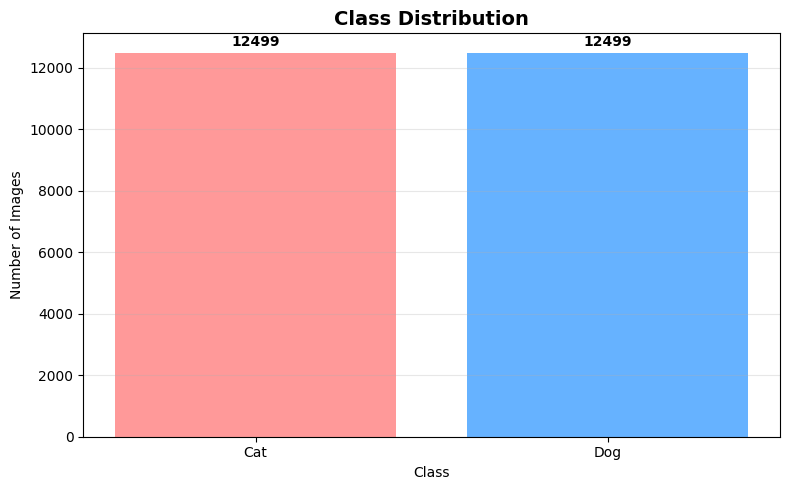


✓ Class distribution plot saved


In [26]:
# Count images per class
cat_path = os.path.join(CONFIG['raw_data_path'], 'Cat')
dog_path = os.path.join(CONFIG['raw_data_path'], 'Dog')

cat_images = [f for f in os.listdir(cat_path) if f.endswith('.jpg')]
dog_images = [f for f in os.listdir(dog_path) if f.endswith('.jpg')]

print(f"Number of cat images: {len(cat_images)}")
print(f"Number of dog images: {len(dog_images)}")
print(f"Total images: {len(cat_images) + len(dog_images)}")

# Class distribution
plt.figure(figsize=(8, 5))
plt.bar(['Cat', 'Dog'], [len(cat_images), len(dog_images)], color=['#FF9999', '#66B2FF'])
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate([len(cat_images), len(dog_images)]):
    plt.text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['experiments_path'], 'class_distribution.png'), dpi=150)
plt.show()

print("\n✓ Class distribution plot saved")

## Data Preprocessing & Augmentation (224x224 RGB)

In [ ]:
# Define transforms for training (with augmentation) and validation/test
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_test_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data Augmentation Pipeline:")
print("  Training:")
print(f"    - Resize to {CONFIG['img_size']}x{CONFIG['img_size']}")
print("    - Random Horizontal Flip (p=0.5)")
print("    - Random Rotation (±15°)")
print("    - Color Jitter (brightness, contrast, saturation)")
print("    - ImageNet Normalization")
print("\n  Validation/Test:")
print(f"    - Resize to {CONFIG['img_size']}x{CONFIG['img_size']}")
print("    - ImageNet Normalization")
print("\n✓ Transforms defined")

Data Augmentation Pipeline:
  Training:
    - Resize to 224x224
    - Random Horizontal Flip (p=0.5)
    - Random Rotation (±15°)
    - Color Jitter (brightness, contrast, saturation)
    - ImageNet Normalization

  Validation/Test:
    - Resize to 224x224
    - ImageNet Normalization

✓ Transforms defined


## Train/Validation/Test Split (80/10/10)

In [29]:
# Custom dataset class
class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None, class_to_idx={'Cat': 0, 'Dog': 1}):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.samples = []
        
        # Load all samples
        for class_name, class_idx in class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.endswith('.jpg'):
                        self.samples.append((os.path.join(class_dir, img_file), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            # Return a blank image if corrupted
            return torch.zeros(3, CONFIG['img_size'], CONFIG['img_size']), label

# Load full dataset
full_dataset = CatsDogsDataset(CONFIG['raw_data_path'], transform=train_transforms)
print(f"Total samples loaded: {len(full_dataset)}")

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(CONFIG['train_split'] * total_size)
val_size = int(CONFIG['val_split'] * total_size)
test_size = total_size - train_size - val_size

print(f"\nDataset Split (80/10/10):")
print(f"  Train: {train_size} samples ({CONFIG['train_split']*100:.0f}%)")
print(f"  Validation: {val_size} samples ({CONFIG['val_split']*100:.0f}%)")
print(f"  Test: {test_size} samples ({CONFIG['test_split']*100:.0f}%)")

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f"\nData Loaders Created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {CONFIG['batch_size']}")
print("\n✓ Dataset split completed")

Total samples loaded: 24998

Dataset Split (80/10/10):
  Train: 19998 samples (80%)
  Validation: 2499 samples (10%)
  Test: 2501 samples (10%)

Data Loaders Created:
  Train batches: 625
  Val batches: 79
  Test batches: 79
  Batch size: 32

✓ Dataset split completed


## Task 2: Model Building - Baseline CNN

In [30]:
# Define baseline CNN architecture
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        
        # Convolutional layers
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 224 -> 112
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 112 -> 56
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 56 -> 28
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 28 -> 14
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.fc_layers(x)
        return x

# Initialize model
model = BaselineCNN(num_classes=2).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Baseline CNN Architecture:")
print(model)
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / (1024**2):.2f} MB (FP32)")
print("\n✓ Model initialized")

Baseline CNN Architecture:
BaselineCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(

## Task 3: Experiment Tracking with MLflow

In [31]:
# Setup MLflow
mlflow.set_tracking_uri(f"file:///{CONFIG['experiments_path']}")
mlflow.set_experiment(CONFIG['experiment_name'])

print("MLflow Configuration:")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"  Experiment: {CONFIG['experiment_name']}")
print(f"  Run name: {CONFIG['run_name']}")
print("\n✓ MLflow initialized")

# Log dataset information
print("\nDataset info to be logged:")
print(f"  Total samples: {total_size}")
print(f"  Train/Val/Test: {train_size}/{val_size}/{test_size}")
print(f"  Image size: {CONFIG['img_size']}x{CONFIG['img_size']}")

c:\Users\swath\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/02/13 21:11:20 INFO mlflow.tracking.fluent: Experiment with name 'cats_dogs_classification' does not exist. Creating a new experiment.


MLflow Configuration:
  Tracking URI: file:///C:\Users\swath\dataset\mlops_project\experiments
  Experiment: cats_dogs_classification
  Run name: baseline_cnn_20260213_211032

✓ MLflow initialized

Dataset info to be logged:
  Total samples: 24998
  Train/Val/Test: 19998/2499/2501
  Image size: 224x224


## Model Training with MLflow Logging

In [35]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print("Training Configuration:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")
print(f"  Number of epochs: {CONFIG['num_epochs']}")
print(f"  Device: {device}")
print("\n✓ Training setup completed")

Training Configuration:
  Loss function: CrossEntropyLoss
  Optimizer: Adam
  Learning rate: 0.001
  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)
  Number of epochs: 10
  Device: cuda

✓ Training setup completed


In [33]:
# Training and validation functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("✓ Training and validation functions defined")

✓ Training and validation functions defined


In [ ]:
# Main training loop with MLflow logging
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Start MLflow run
with mlflow.start_run(run_name=CONFIG['run_name']) as run:
    # Store run ID for later use
    run_id = run.info.run_id
    
    # Log hyperparameters
    mlflow.log_params({
        'model_architecture': 'BaselineCNN',
        'img_size': CONFIG['img_size'],
        'batch_size': CONFIG['batch_size'],
        'learning_rate': CONFIG['learning_rate'],
        'num_epochs': CONFIG['num_epochs'],
        'optimizer': 'Adam',
        'loss_function': 'CrossEntropyLoss',
        'train_samples': train_size,
        'val_samples': val_size,
        'test_samples': test_size,
        'total_params': total_params
    })
    
    print(f"\n{'='*60}")
    print(f"Starting Training - Run ID: {run_id}")
    print(f"{'='*60}\n")
    
    best_val_loss = float('inf')
    best_model_path = os.path.join(CONFIG['models_path'], 'best_model.pt')
    
    for epoch in range(CONFIG['num_epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
        print("-" * 40)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Log metrics to MLflow
        mlflow.log_metrics({
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'learning_rate': optimizer.param_groups[0]['lr']
        }, step=epoch)
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc
            }, best_model_path)
            print(f"✓ Best model saved (val_loss: {val_loss:.4f})")
    
    print(f"\n{'='*60}")
    print("Training Completed!")
    print(f"{'='*60}\n")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Best model saved to: {best_model_path}")
    
    # Log final model to MLflow
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_artifact(best_model_path)
    
    print("\n✓ Model logged to MLflow")

# Store run_id for later cells
print(f"\nRun ID stored: {run_id}")


Starting Training - Run ID: 400a118275cf433f98b0a1e87794bed7


Epoch 1/10
----------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

## Artifacts: Loss Curves

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
loss_curves_path = os.path.join(CONFIG['experiments_path'], 'training_curves.png')
plt.savefig(loss_curves_path, dpi=150, bbox_inches='tight')
plt.show()

# Log to MLflow
with mlflow.start_run(run_id=run_id):
    mlflow.log_artifact(loss_curves_path)

print(f"\n✓ Training curves saved and logged to MLflow")

## Model Evaluation on Test Set

In [ ]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Evaluating best model on test set...")
print(f"Loaded model from epoch {checkpoint['epoch']+1}")
print(f"Validation accuracy: {checkpoint['val_acc']:.2f}%\n")

# Evaluate on test set
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")

# Log test metrics
with mlflow.start_run(run_id=run_id):
    mlflow.log_metrics({
        'test_loss': test_loss,
        'test_accuracy': test_acc
    })

print("\n✓ Test metrics logged to MLflow")

In [ ]:
# Generate predictions for confusion matrix
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Generating predictions'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

test_preds, test_labels = get_predictions(model, test_loader, device)
print(f"\nGenerated {len(test_preds)} predictions")

## Artifacts: Confusion Matrix

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
class_names = ['Cat', 'Dog']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentages
for i in range(len(class_names)):
    for j in range(len(class_names)):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
cm_path = os.path.join(CONFIG['experiments_path'], 'confusion_matrix.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()

# Log to MLflow
with mlflow.start_run(run_id=run_id):
    mlflow.log_artifact(cm_path)

print("\n✓ Confusion matrix generated and logged")

# Print classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

## Model Serialization (.pt, .pkl formats)

In [ ]:
# Save model in multiple serialized formats
print("Serializing trained model...\n")

# 1. PyTorch format (.pt)
pt_model_path = os.path.join(CONFIG['models_path'], 'baseline_cnn.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': 'BaselineCNN',
    'img_size': CONFIG['img_size'],
    'num_classes': 2,
    'test_accuracy': test_acc,
    'class_names': class_names
}, pt_model_path)
print(f"✓ PyTorch model (.pt) saved: {pt_model_path}")
print(f"  Size: {os.path.getsize(pt_model_path) / (1024**2):.2f} MB")

# 2. Pickle format (.pkl)
pkl_model_path = os.path.join(CONFIG['models_path'], 'baseline_cnn.pkl')
with open(pkl_model_path, 'wb') as f:
    pickle.dump({
        'model': model,
        'config': CONFIG,
        'class_names': class_names,
        'test_accuracy': test_acc
    }, f)
print(f"\n✓ Pickle model (.pkl) saved: {pkl_model_path}")
print(f"  Size: {os.path.getsize(pkl_model_path) / (1024**2):.2f} MB")

# Log model artifacts to MLflow
with mlflow.start_run(run_id=run_id):
    mlflow.log_artifact(pt_model_path)
    mlflow.log_artifact(pkl_model_path)

print("\n✓ All model artifacts logged to MLflow")

In [ ]:
# M1 Completion Summary
print("\n" + "="*70)
print("M1: MODEL DEVELOPMENT & EXPERIMENT TRACKING - COMPLETED")
print("="*70)
print("\n✓ Task 1: Data & Code Versioning (Git + DVC)")
print("✓ Task 2: Model Building (Baseline CNN)")
print("✓ Task 3: Experiment Tracking (MLflow)")
print(f"\nModels saved: {CONFIG['models_path']}")
print(f"Experiments: {CONFIG['experiments_path']}")
print(f"\nView MLflow UI:")
print(f"  mlflow ui --backend-store-uri file:///{CONFIG['experiments_path']}")
print("  Open: http://localhost:5000")
print("="*70)